# 3 - An Introduction to Working with Annuli

This Notebooks works through how we can work with annuli of line emission to infer their velocity structure. Using the full line emission can be beneficial to using just the collapsed rotation map as you have more information to work with.

For this Tutorial, we will use the TW Hya data that we used in the [first tutorial](https://eddy.readthedocs.io/en/latest/tutorials/tutorial_1.html) which is from [Huang et al. (2018)](https://ui.adsabs.harvard.edu/#abs/2018ApJ...852..122H), and downloadable from [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PXDKBC), or using the cell below with `wget`.

In [1]:
import os
if not os.path.exists('TWHya_CO_cube.fits'):
    !wget -O TWHya_CO_cube.fits -q https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/PXDKBC/QULHRK

## `linecube`

 This time we do not want to collapse the data to a rotation map, but keep it as a full line cube. As such, we use the `linecube` class from `eddy`, rather than the `rotationmap`.

In [2]:
import matplotlib.pyplot as plt
from eddy import linecube
import numpy as np

Let's load up the data. Again, we can use the same field of view argument, `FOV`, to cut down the field of view.

In [3]:
cube = linecube('TWHya_CO_cube.fits', FOV=8.0)

### Inspecting the Data

Unlike for `rotationmap`, a `linecube` instance will be 3D, with the third dimension representing the spectral dimension. This can be seen by plotting the integrated spectrum with the `plot_spectrum` function which basically integrating the flux in each channel.

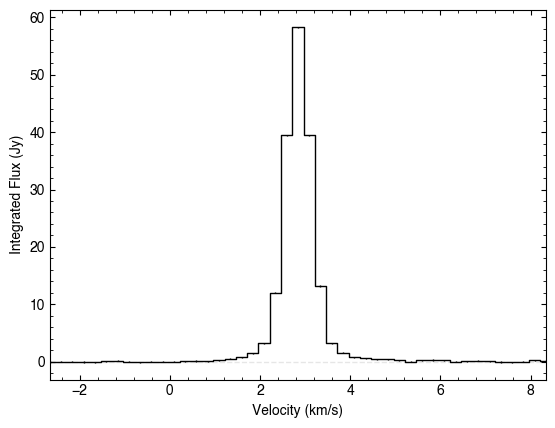

In [4]:
cube.plot_spectrum()

You can clearly see the spectrum is centred on a velocity of $\sim 2.84~{\rm km\,s^{-1}}$, the systemic velocity of TW Hya. Another way to inspect the data is to plot the peak intensity along every line of sight. This can be achieved with the `plot_maximum` function.

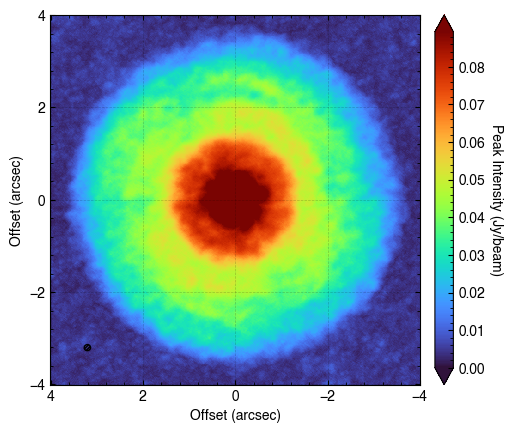

In [5]:
cube.plot_maximum()

Here it's obvious to see that the CS emission has a ring-like morphology and extends out to about $2.5^{\prime\prime}$. This is always a good check to make as you can see whether the data is well centered or not.

## `annulus`

The main focus of this tutorial, however, is working with the `annulus` class. This contains an ensemble of spectra extracted from the `linecube` based on some geometrical cuts (usually just a small radial range). This is useful because if we expect the disk to be azimuthally symmetric, then these spectra should have the same form (i.e., peak and width), but have their line centers shifted due to the projected velocity structure of the disk. Leveraging this assumption that the line profiles should _look_ the same, we can use this to infer the underlying velocity structure.

### Extracting an `annulus`

To extract an annulus, we simply use the `get_annulus` function, specifying the disk properties and the region we're interested in. By default, this will select a random sample of _spatially independent_ pixels from the cube. Remember, if we want to assume that all the spectra look the same, then we only want a small radial range.

In [6]:
annulus = cube.get_annulus(r_min=1.0, r_max=1.1, inc=6.5, PA=151.0)

### Inspecting an `annulus`

We can quickly see spectra that we've selected through `plot_spectra`:

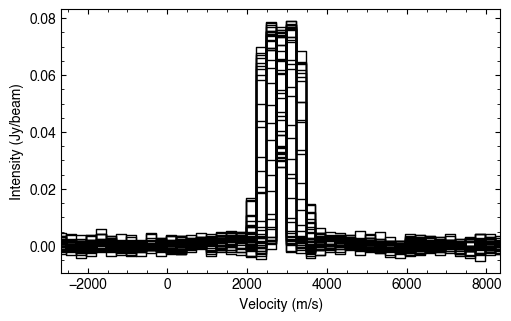

In [7]:
annulus.plot_spectra()

This figure shows that all the lines look similar, but are spread out along the velocity axis due to the Doppler shift of the lines. Another useful function is `plot_river`:

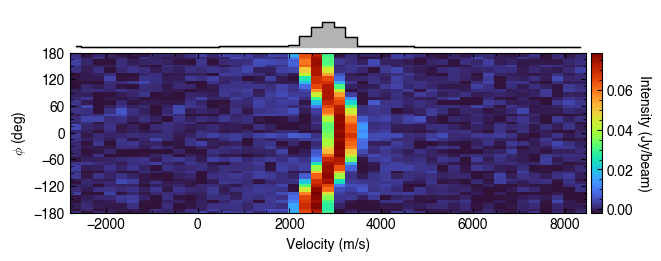

In [8]:
annulus.plot_river()

What this figure shows with the colored panel are each of the spectra stacked on top of one another; each row represents a spectrum. So you can see at $\phi = 0^{\circ}$, the red-shifted axis (remember in `eddy` the ${\rm PA}$ is always measured to the red-shifted axis, and the deprojected polar coordinate $\phi$ is measured from this axis in an east-of-north direction) has the peak at around $3.2~{\rm km\,s^{-1}}$, while the blue-shifted axis, $\phi = \pm 180^{\circ}$, has the peak around $2.4~{\rm km\,s^{-1}}$.

The top panel shows the azimuthally averaged spectrum. This is exceptionally broad as we're averaging over spectra with a large range of line centroids.

### Inferring Rotation Velocity

The most basic approach to accounting for this velocity shift is to model the line centroid as a very simple harmonic oscillator:

$$
v_0(\phi) = v_{\phi} \cos(\phi) \sin(i) + v_{\rm LSR}
$$

This can be easily done with the `get_vlos_SHO` function. In short, this determins the line centroid for each spectrum in the `annulus`, then fits $v_{\phi}$ and $v_{\rm LSR}$ to best recover the observation. By default, the function will use the `quadratic` method described in [Teague & Foreman-Mackey (2018)](https://ui.adsabs.harvard.edu/#abs/2018RNAAS...2c.173T) to fit the line centroids, and will return both $v_{\phi}$ and $v_{\rm LSR}$ and their associated uncertainties.

In [9]:
annulus.get_vlos_SHO()

(array([2981.520601  , 2833.29483318]), array([19.27409737,  1.56866151]))

There are three methods implemented in `eddy` to determine the line centroid:

* `'quadratic'` - The method described in [Teague & Foreman-Mackey (2018)](https://ui.adsabs.harvard.edu/#abs/2018RNAAS...2c.173T). This is only good when the line is only partially resolved.

* `'max'` - Assumes the line center is the velocity of the channel with the peak intensity in. This is the fastest, but is limited by the spectral resolution of the data and the noise.

* `'gaussian'` - Finds the line center by fitting a Gaussian profile to it.

* `'gaussthick'` - Finds the line center by fitting an optically thick Gaussian profile to it.

* `'doublegauss'` - Fits two Gaussian components to each spectrum, taking the larger of the two as the 'main' component. This is very chaotic and should be used with caution.

To understand the quality of the fit, we can use the convenience function, `plot_centroids` to show our data, and overplot the fit. Note this function also takes the `centroid_method` arugment to change between the different methods described above.

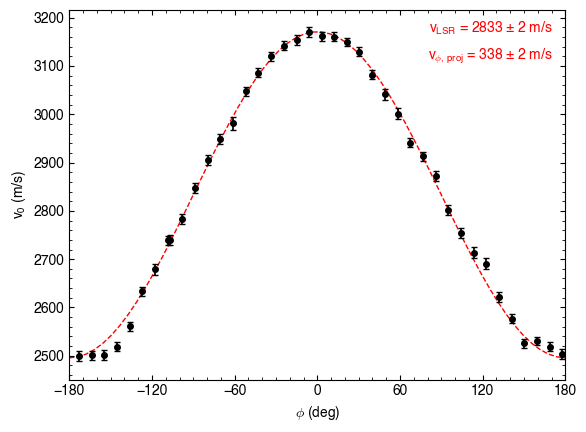

In [10]:
annulus.plot_centroids(plot_fit=True, centroid_method='quadratic')

Note that here what's annotated is $v_{\phi,\,{\rm proj}} = v_{\phi} \sin(i)$. In general, any symbol with the ${\rm proj}$ subscript means taking into account the projection from the disk inclination.

As another check that this is the correct velocity, we can use this to 'straighten out' the river plot from above by providing it the projected rotational velocity.

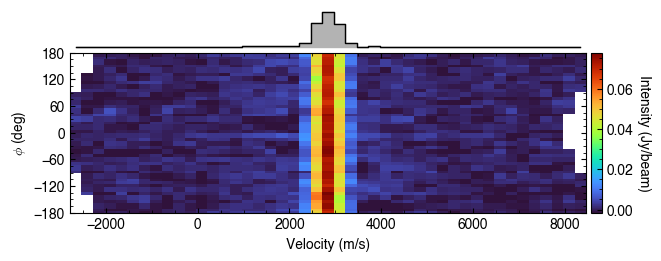

In [11]:
annulus.plot_river(vrot=annulus.get_vlos_SHO()[0][0])

We can easily see that this correction has straightened out the river and tightened up the azimuthally averaged spectrum. It is this approach that we use with [GoFish](https://github.com/richteague/gofish) to tease out weak emission lines.

### Radial and Vertical Velocities

Radial and vertical velocities may also be present. We can extend the simple SHO model above to account for this:

$$
v_0(\phi) = v_{\phi} \cos(\phi) \sin(i) - v_{\rm r} \sin(\phi) \sin(i) - v_{\rm z} \cos(i) + v_{\rm LSR}.
$$

Here we use the sign of the disk inclination, $i$, to encode the direction of rotation for the disk: a positive inclination means clockwise rotation, while a negative inclination means an anti-clockwise rotation. This rotation direction is inherited when using `get_annulus`. In this form, positive $v_{\rm r}$ values are moving _away_ from the star and positive $v_{\rm z}$ values are moving away from the midplane.

To include the radial component, most functions allow for a `fit_vrad` argument. Similarly, we also provide a `fix_vlsr` value which specifies the systemic velocity of the disk. If this is not provided, what is returned is $v_{\rm LSR} - v_{\rm z} \cos(i)$. When `fix_vlsr` is provided, you will see that a $v_{\rm z,\, proj}$ is returned, while without it, only a $v_{\rm LSR}$ is returned

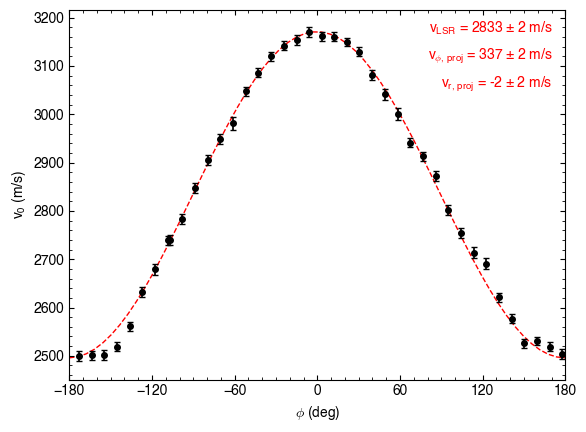

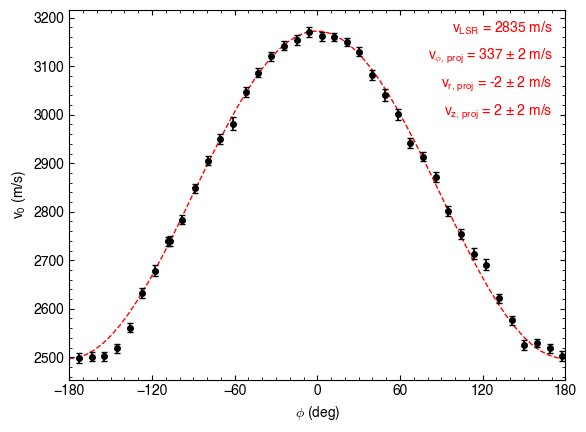

In [12]:
annulus.plot_centroids(plot_fit=True, fit_vrad=True, centroid_method='quadratic')

annulus.plot_centroids(plot_fit=True, fit_vrad=True, fix_vlsr=2.835e3, centroid_method='quadratic')

## Velocity Profiles

The `linecube` class provides a wrapper for splitting the disk into concentric annuli assuming a source geometry, and then calculating the rotational and, if requested, radial velocity profiles. 

---

**NOTE**: This approach is different to the one implemented in [ConeRot](https://github.com/simoncasassus/ConeRot) which allows each annulus to be described by a different set of geometrical parameters.

---

This is the `get_velocity_profile` function, as demonstrated below. By default it will calculate the profile for the whole image with bin annuli of 1/4 the beam major axis size, however for this we trim down the region to speed things up. For this Tutorial, we will stick with the `fit_method='SHO'`. Other fit methods are discussed in [a second Tutorial](https://eddy.readthedocs.io/en/latest/tutorials/tutorial_4.html).

In [13]:
r, v, dv = cube.get_velocity_profile(x0=0.0, y0=0.0, inc=6.0, PA=151.0,
                                     fit_vrad=True, fit_method='SHO',
                                     get_vlos_kwargs=dict(centroid_method='quadratic'),
                                     rbins=np.arange(0.3, 3.0, 0.25 * cube.bmaj))

This function will return three arrays: the bin centers, the velocity profiles and the uncertainties on the velocity profiles. Note that this will return _deprojected_ velocities, taking into account the disk projection. Here positive $v_{\rm r}$ are velocities moving _away_ from the star, while positive $v_{\rm z}$ values are moving _away_ from the disk midplane.

In this example above we didn't set the `fix_vlsr` value, such that the third velocity component is the sum of the systemic velocity and the projection of the vertical component (this should be clear as the values are typically measured in the km/s rather than the m/s).

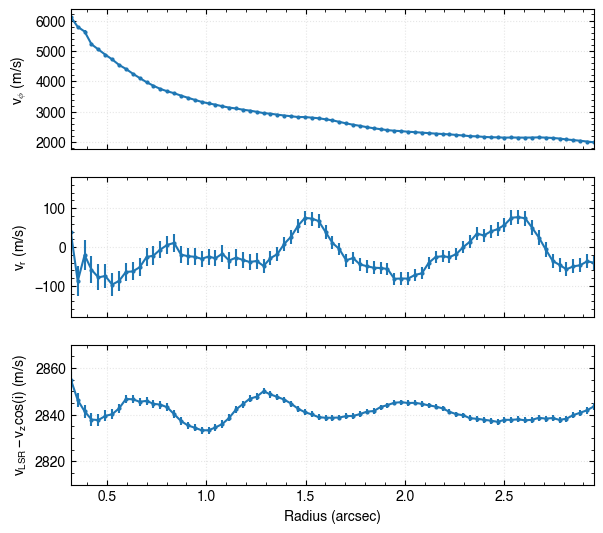

In [14]:
fig, axs = plt.subplots(figsize=(6.75, 6.17), nrows=3)

axs[0].grid(ls=':', color='0.9')
axs[0].errorbar(r, v[0], dv[0], marker='o', ms=2)
axs[0].set_xticklabels([])
axs[0].set_ylabel(r'$v_{\rm \phi}$' + ' (m/s)')

axs[1].grid(ls=':', color='0.9')
axs[1].errorbar(r, v[1], dv[1], marker='o', ms=2)
axs[1].set_xticklabels([])
axs[1].set_ylabel(r'$v_{\rm r}$' + ' (m/s)')
axs[1].set_ylim(-180, 180)

axs[2].grid(ls=':', color='0.9')
axs[2].errorbar(r, v[2], dv[2], marker='o', ms=2)
axs[2].set_xlabel('Radius (arcsec)')
axs[2].set_ylabel(r'$v_{\rm LSR} - v_{\rm z} \cos(i)$' + ' (m/s)')
axs[2].set_ylim(2810, 2870)

for ax in axs:
    ax.set_xlim(r[0], r[-1])
fig.align_labels(axs)

Repeating the above, but now specifying `fix_vlsr`, we can see that the third velocity component is now $v_{\rm z}$. 

In [15]:
r, v, dv = cube.get_velocity_profile(x0=0.0, y0=0.0, inc=6.0, PA=151.0,
                                     fit_vrad=True, fix_vlsr=2.84e3, fit_method='SHO',
                                     get_vlos_kwargs=dict(centroid_method='quadratic'),
                                     rbins=np.arange(0.3, 3.0, 0.25 * cube.bmaj))

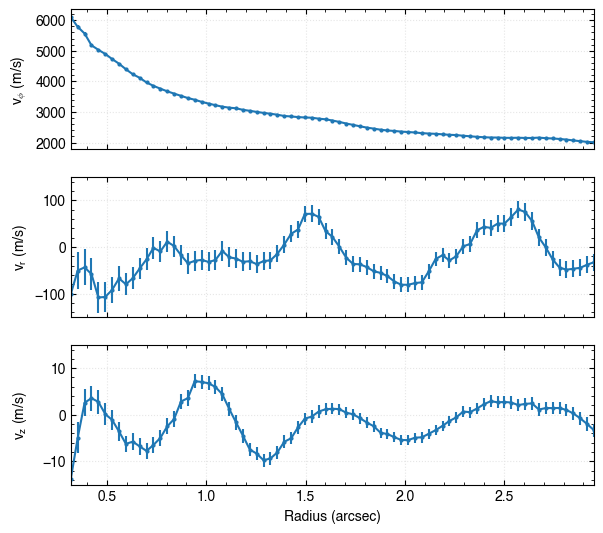

In [16]:
fig, axs = plt.subplots(figsize=(6.75, 6.17), nrows=3)

axs[0].grid(ls=':', color='0.9')
axs[0].errorbar(r, v[0], dv[0], marker='o', ms=2)
axs[0].set_xticklabels([])
axs[0].set_ylabel(r'$v_{\rm \phi}$' + ' (m/s)')

axs[1].grid(ls=':', color='0.9')
axs[1].errorbar(r, v[1], dv[1], marker='o', ms=2)
axs[1].set_xticklabels([])
axs[1].set_ylabel(r'$v_{\rm r}$' + ' (m/s)')
axs[1].set_ylim(-150, 150)

axs[2].grid(ls=':', color='0.9')
axs[2].errorbar(r, v[2], dv[2], marker='o', ms=2)
axs[2].set_xlabel('Radius (arcsec)')
axs[2].set_ylabel(r'$v_{\rm z}$' + ' (m/s)')
axs[2].set_ylim(-15, 15)

for ax in axs:
    ax.set_xlim(r[0], r[-1])
fig.align_labels(axs)

### Multiple Iterations

This approch often yields uncertainties (if they do at all!) that are implausibly small and more than likely reflect the inflexibility in the model. One approach to circumvent this is use the `niter` argument to calculate several different velocity profiles, each using annuli with different pixels (at least statistically, each annulus is taken with a random draw of pixels), and then taking a weighted average over the samples.

In [17]:
r, v, dv = cube.get_velocity_profile(x0=0.0, y0=0.0, inc=6.0, PA=151.0,
                                     fit_vrad=True, fix_vlsr=2.84e3, fit_method='SHO',
                                     get_vlos_kwargs=dict(centroid_method='gaussian'),
                                     rbins=np.arange(0.3, 3.0, 0.25 * cube.bmaj),
                                     niter=5)

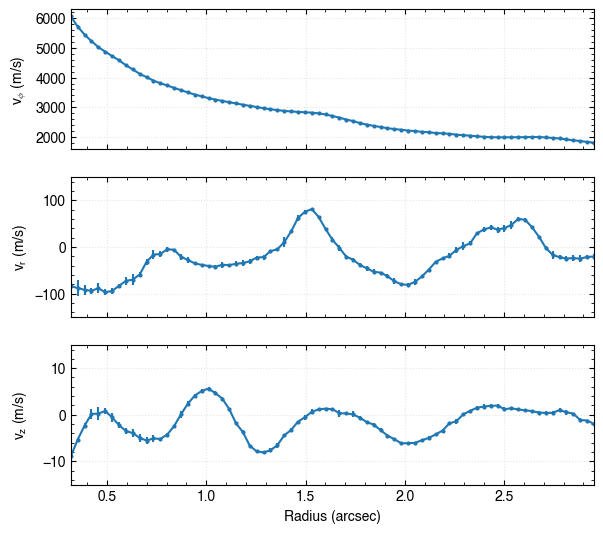

In [18]:
fig, axs = plt.subplots(figsize=(6.75, 6.17), nrows=3)

axs[0].grid(ls=':', color='0.9')
axs[0].errorbar(r, v[0], dv[0], marker='o', ms=2)
axs[0].set_xticklabels([])
axs[0].set_ylabel(r'$v_{\rm \phi}$' + ' (m/s)')

axs[1].grid(ls=':', color='0.9')
axs[1].errorbar(r, v[1], dv[1], marker='o', ms=2)
axs[1].set_xticklabels([])
axs[1].set_ylabel(r'$v_{\rm r}$' + ' (m/s)')
axs[1].set_ylim(-150, 150)

axs[2].grid(ls=':', color='0.9')
axs[2].errorbar(r, v[2], dv[2], marker='o', ms=2)
axs[2].set_xlabel('Radius (arcsec)')
axs[2].set_ylabel(r'$v_{\rm z}$' + ' (m/s)')
axs[2].set_ylim(-15, 15)

for ax in axs:
    ax.set_xlim(r[0], r[-1])
fig.align_labels(axs)

### A `rotationmap` Wrapper

You may have noticed that this approach of splitting the data into annuli, calculating the centroids of each spectrum within each annulus and then fitting a SHO model can be accelerated if we already have a map of the line centroids, as we worked with in the [previous tutorial](https://eddy.readthedocs.io/en/latest/tutorials/tutorial_1.html). 

In fact, `rotationmap` has a similar functionailty, `fit_annuli`, which performs the same process, but without having to calculate the line centroids each time. This also has the option to return the linearly interpolated model and residuals using the same `returns` argument as found for `fit_map`. There are many more options for this function, and we encourage the reader to read the documentation for find more.

Assuming uncertainties in TWHya_CO_cube_dv0.fits.


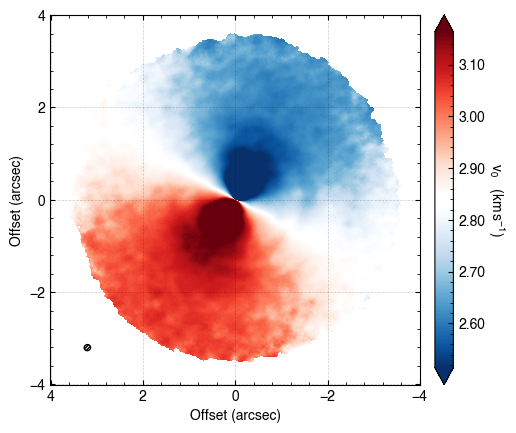

In [19]:
from eddy import rotationmap
import numpy as np
cube = rotationmap('TWHya_CO_cube_v0.fits', FOV=8.0)
cube.plot_data()

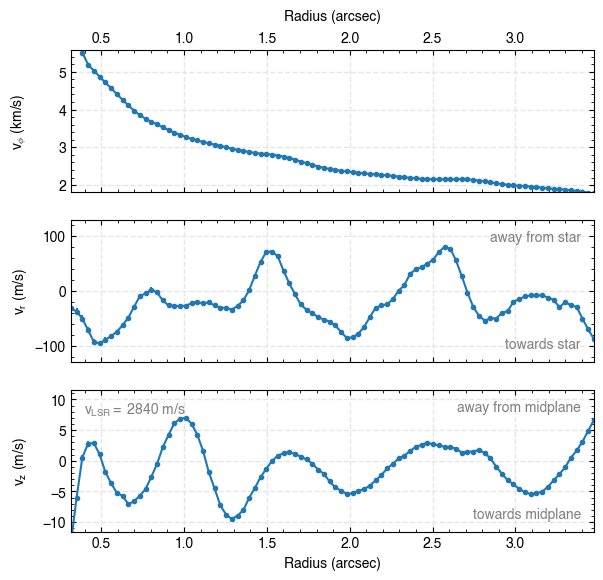

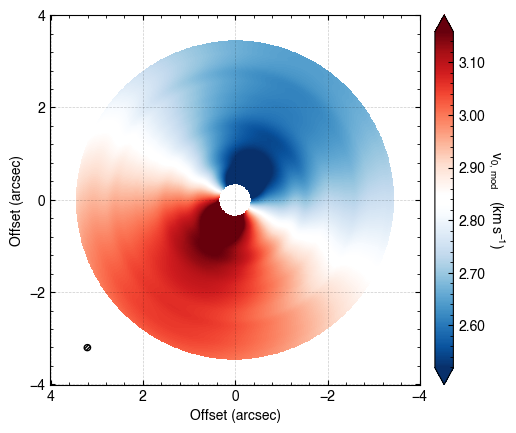

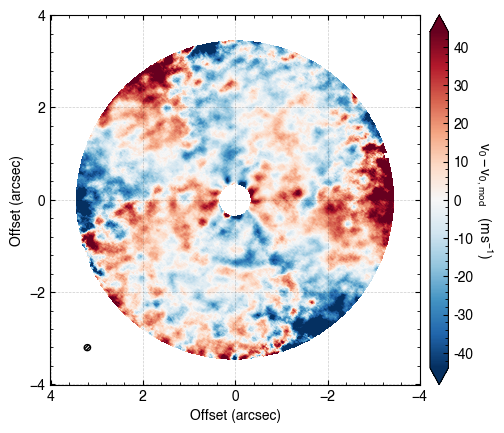

In [20]:
r, v, dv = cube.fit_annuli(x0=0.0, y0=0.0, inc=6.0, PA=151.0, 
                           fit_vrad=True, fix_vlsr=2.84e3,
                           rbins=np.arange(0.3, 3.5, 0.25 * cube.bmaj))